<a href="https://colab.research.google.com/github/danielpatrickhug/GitModel/blob/main/bottom_up_vs_top_down.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick review of kernels and message passing

In [1]:
%%capture
%%bash

pip install sentence-transformers

In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
from torch import Tensor
import pandas as pd
import math

In [28]:
def embed_data(data, key='query', model_name='all-MiniLM-L6-v2', cores=1, gpu=False, batch_size=128):
    """
    Embed the sentences/text using the MiniLM language model (which uses mean pooling)
    """
    print('Embedding data')
    model = SentenceTransformer(model_name)
    print('Model loaded')

    sentences = data[key].tolist()
    unique_sentences = data[key].unique()
    print('Unique sentences', len(unique_sentences))

    if cores == 1:
        embeddings = model.encode(unique_sentences, show_progress_bar=True, batch_size=batch_size)
    else:
        devices = ['cpu'] * cores
        if gpu:
            devices = None  # use all CUDA devices

        # Start the multi-process pool on multiple devices
        print('Multi-process pool starting')
        pool = model.start_multi_process_pool(devices)
        print('Multi-process pool started')

        chunk_size = math.ceil(len(unique_sentences) / cores)

        # Compute the embeddings using the multi-process pool
        embeddings = model.encode_multi_process(unique_sentences, pool, batch_size=batch_size, chunk_size=chunk_size)
        model.stop_multi_process_pool(pool)

    print("Embeddings computed")

    mapping = {sentence: embedding for sentence, embedding in zip(unique_sentences, embeddings)}
    embeddings = np.array([mapping[sentence] for sentence in sentences])
  
    return embeddings

In [113]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.',
    "Where was Marie Curie born?",
    "Maria Sklodowska, later known as Marie Curie, was born on November 7, 1867.",
    "Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie, a doctor of French Catholic origin from Alsace."]

data = [(i, sent) for i, sent in enumerate(sentences)]
data = pd.DataFrame(data, columns=['id', 'query'])

In [67]:
#Bottom up adj matrix
def cosine_similarity(a, b):
    """
    inner product between two vectors divided by the norm
    :a: n-dim feature vector
    :b: n-dim feature vector
    :return: the cosine similarity of the two embeddings
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(np.array(a))

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(np.array(b))
    return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

def adjaceny_matrix(sentence_embeddings):
    A = torch.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
    for i in range(sentence_embeddings.shape[0]):
        for j in range(sentence_embeddings.shape[0]):
            i_j_sim = cosine_similarity(sentence_embeddings[i], sentence_embeddings[j])
            A[i, j] = i_j_sim
    return A

#kernel
def cos_sim(a: Tensor, b: Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(np.array(a))

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(np.array(b))

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [68]:
MODEL_NAME = "all-MiniLM-L6-v2" #"allenai-specter"#
embs = embed_data(data,model_name=MODEL_NAME)

Embedding data
Model loaded
Unique sentences 6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings computed


In [69]:
threshold=0.7

##kernel


In [70]:
A = cos_sim(embs, embs) 
adj_matrix = torch.zeros_like(A)
adj_matrix[A > threshold] = 1
adj_matrix[A <= threshold] = 0

##bottom-up

In [71]:
A_b = adjaceny_matrix(embs)
adj_matrix_b = torch.zeros_like(A_b)
adj_matrix_b[A_b > threshold] = 1
adj_matrix_b[A_b <= threshold] = 0

### thresholded map connections are equal 

In [72]:
adj_matrix == adj_matrix_b

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

## Message Passing

In [143]:
def k_hop_message_passing(A, node_features, k):
    """
    Compute the k-hop adjacency matrix and aggregated features using message passing.

    Parameters:
    A (numpy array): The adjacency matrix of the graph.
    node_features (numpy array): The feature matrix of the nodes.
    k (int): The number of hops for message passing.

    Returns:
    A_k (numpy array): The k-hop adjacency matrix.
    agg_features (numpy array): The aggregated feature matrix for each node in the k-hop neighborhood.
    """

    print("Compute the k-hop adjacency matrix")
    A_k = np.linalg.matrix_power(A, k)

    print("Aggregate the messages from the k-hop neighborhood:")
    agg_features = node_features.copy()

    for i in range(k):
        agg_features += np.matmul(np.linalg.matrix_power(A, i+1), node_features)

    return A_k, agg_features

In [144]:
A_k, agg = k_hop_message_passing(adj_matrix, embs, 2)
A_k

Compute the k-hop adjacency matrix
Aggregate the messages from the k-hop neighborhood:


array([[2., 2., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 3., 3., 3.],
       [0., 0., 0., 3., 3., 3.],
       [0., 0., 0., 3., 3., 3.]], dtype=float32)

U: (6, 6)

S: (6,)

VT: (6, 6)



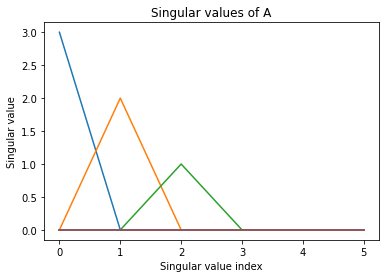

In [154]:
U, S, VT = np.linalg.svd(adj_matrix)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()

In [127]:
agg==embs

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [128]:
embs==embs

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [146]:
import torch
import math
import matplotlib.pyplot as plt

def k_hop_message_passing(A, node_features, exp):
    # Convert adjacency matrix and node features to PyTorch tensors
    A = torch.tensor(A)
    node_features = torch.tensor(node_features)
    
    # Compute the k-hop adjacency matrix using PyTorch
    A_k = A.clone().detach().float()
    for i in range(int(exp)-1):
        A_k = torch.matmul(A_k, A)
    
    # Compute the aggregated features using PyTorch
    agg_features = torch.matmul(A_k, node_features)
    
    # Exponentiate the k-hop adjacency matrix by exp using PyTorch
    A_k_exp = A_k ** exp
    
    # Return the exponentiated matrix and aggregated features as NumPy arrays
    return A_k_exp.numpy(), agg_features.numpy()


In [147]:
#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.',
    "Where was Marie Curie born?",
    "Maria Sklodowska, later known as Marie Curie, was born on November 7, 1867.",
    "Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie, a doctor of French Catholic origin from Alsace."]

data = [(i, sent) for i, sent in enumerate(sentences)]
data = pd.DataFrame(data, columns=['id', 'query'])
embs = embed_data(data)
print(embs.shape)
A = cos_sim(embs, embs)
adj_matrix = torch.zeros_like(A)
adj_matrix[A > 0.5] = 1
adj_matrix[A <= 0.5] = 0
A_k, agg_features = k_hop_message_passing(adj_matrix, embs, math.e)
A_k

Embedding data
Model loaded
Unique sentences 6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings computed
(6, 384)


<ipython-input-146-755027329b31>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)


array([[ 6.5808854,  6.5808854,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 6.5808854,  6.5808854,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , 19.812988 , 19.812988 ,
        19.812988 ],
       [ 0.       ,  0.       ,  0.       , 19.812988 , 19.812988 ,
        19.812988 ],
       [ 0.       ,  0.       ,  0.       , 19.81299  , 19.81299  ,
        19.81299  ]], dtype=float32)

U: (6, 6)

S: (6,)

VT: (6, 6)



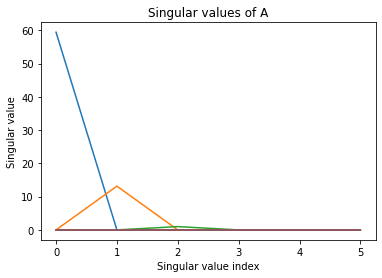

In [148]:
U, S, VT = np.linalg.svd(A_k)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()

In [150]:
A_k, agg_features = k_hop_message_passing(adj_matrix, embs, math.pi)
A_k

<ipython-input-146-755027329b31>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)


array([[ 77.88024,  77.88024,   0.     ,   0.     ,   0.     ,   0.     ],
       [ 77.88024,  77.88024,   0.     ,   0.     ,   0.     ,   0.     ],
       [  0.     ,   0.     ,   1.     ,   0.     ,   0.     ,   0.     ],
       [  0.     ,   0.     ,   0.     , 995.0418 , 995.0418 , 995.0418 ],
       [  0.     ,   0.     ,   0.     , 995.0418 , 995.0418 , 995.0418 ],
       [  0.     ,   0.     ,   0.     , 995.0416 , 995.0416 , 995.0416 ]],
      dtype=float32)

U: (6, 6)

S: (6,)

VT: (6, 6)



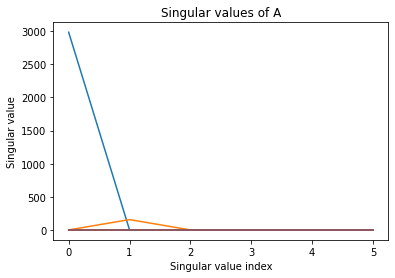

In [151]:
U, S, VT = np.linalg.svd(A_k)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()

In [152]:
import math

phi = (1 + math.sqrt(5)) / 2
A_k, agg_features = k_hop_message_passing(adj_matrix, embs, phi)
A_k

<ipython-input-146-755027329b31>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)


array([[1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.]], dtype=float32)

U: (6, 6)

S: (6,)

VT: (6, 6)



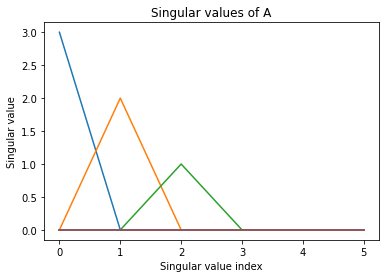

In [153]:
U, S, VT = np.linalg.svd(A_k)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()

In [99]:
adj_matrix

tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.]])

In [100]:
cos_sim(agg_features, embs)

tensor([[ 0.8769,  0.8769,  0.1264,  0.0061, -0.0484, -0.0160],
        [ 0.8769,  0.8769,  0.1264,  0.0061, -0.0484, -0.0160],
        [ 0.1181,  0.1036,  1.0000, -0.0194, -0.0224, -0.0172],
        [ 0.0307, -0.0703, -0.0228,  0.9048,  0.8509,  0.8294],
        [ 0.0307, -0.0703, -0.0228,  0.9048,  0.8509,  0.8294],
        [ 0.0307, -0.0703, -0.0228,  0.9048,  0.8509,  0.8294]])

In [102]:
cos_sim(embs, embs)

tensor([[ 1.0000,  0.5381,  0.1181,  0.0364, -0.0141,  0.0571],
        [ 0.5381,  1.0000,  0.1036, -0.0257, -0.0708, -0.0852],
        [ 0.1181,  0.1036,  1.0000, -0.0194, -0.0224, -0.0172],
        [ 0.0364, -0.0257, -0.0194,  1.0000,  0.6973,  0.6416],
        [-0.0141, -0.0708, -0.0224,  0.6973,  1.0000,  0.5024],
        [ 0.0571, -0.0852, -0.0172,  0.6416,  0.5024,  1.0000]])

In [105]:
from typing import List, Tuple
def linearly_sum_gnn_heads(
    matrices: List[Tuple[np.ndarray, np.ndarray]], normalization_fn: str = "max"
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Linearly sum a list of adjacency matrices and normalize the result. Also computes the average of the node embeddings
    and checks that the number of documents in the adjacency matrices matches the number of documents in the embeddings set.

    Parameters:
    matrices (List of Tuple): List of tuples where each tuple contains an adjacency matrix and its
        corresponding node embeddings.

    Returns:
    normalized_matrix (numpy array): The linearly summed and normalized adjacency matrix.
    avg_embeddings (numpy array): The average node embeddings.
    """
    if len(matrices) == 1:
        return matrices[0]
    # Compute the average of the embeddings
    avg_embeddings = np.mean([t[1] for t in matrices], axis=0)

    # Check that the number of documents in the adjacency matrices matches the number of documents in the embeddings set
    num_docs_adj = matrices[0][0].shape[0]
    num_docs_embs = avg_embeddings.shape[0]
    if num_docs_adj != num_docs_embs:
        raise ValueError(
            "Number of documents in adjacency matrix does not match number of documents in embeddings set."
        )

    # Linearly sum the adjacency matrices and normalize the matrix by dividing it by the maximum value
    summed_matrix = sum([t[0] for t in matrices])
    if normalization_fn == "max":
        max_value = np.max(summed_matrix)
        normalized_matrix = summed_matrix / max_value
    elif normalization_fn == "sum":
        normalized_matrix = summed_matrix / len(matrices)
    elif normalization_fn == "min-max":
        min_value = np.min(summed_matrix)
        max_value = np.max(summed_matrix)
        normalized_matrix = (summed_matrix - min_value) / (max_value - min_value)
    elif normalization_fn == "z_score":
        mean = np.mean(summed_matrix)
        std = np.std(summed_matrix)
        normalized_matrix = (summed_matrix - mean) / std
    elif normalization_fn == "circular":
        min_value = np.min(summed_matrix)
        max_value = np.max(summed_matrix)
        normalized_matrix_linear = (summed_matrix - min_value) / (max_value - min_value)
        normalized_matrix = np.sin(2 * np.pi * normalized_matrix_linear)
    else:
        raise ValueError(f"Normalization function {normalization_fn} not supported.")

    A_k, agg_embs = k_hop_message_passing(normalized_matrix, avg_embeddings, 1)
    print(f"adj matrix shape: {A_k.shape}")
    print(f"agg embeddings shape: {agg_embs.shape}")
    return A_k, agg_embs

In [140]:
matricies = [k_hop_message_passing(adj_matrix, embs, math.e),k_hop_message_passing(adj_matrix, embs, math.pi), k_hop_message_passing(adj_matrix, embs, phi)]
A_k, agg_embs = linearly_sum_gnn_heads(matricies, "sum")

adj matrix shape: (6, 6)
agg embeddings shape: (6, 384)


<ipython-input-139-755027329b31>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)


In [141]:
A_k

array([[ 28.487043,  28.487043,   0.      ,   0.      ,   0.      ,
          0.      ],
       [ 28.487043,  28.487043,   0.      ,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   1.      ,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , 338.61826 , 338.61826 ,
        338.61826 ],
       [  0.      ,   0.      ,   0.      , 338.61826 , 338.61826 ,
        338.61826 ],
       [  0.      ,   0.      ,   0.      , 338.6182  , 338.6182  ,
        338.6182  ]], dtype=float32)

U: (6, 6)

S: (6,)

VT: (6, 6)



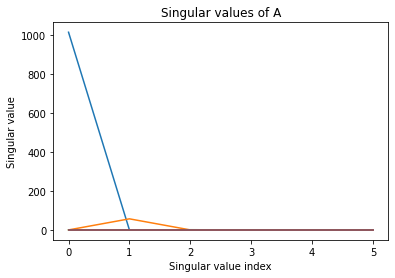

In [142]:
U, S, VT = np.linalg.svd(A_k)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()